# Daisyworld with greenhouse gases

In this notebook we will study a model that introduces greenhouse gases into Daisyworld. This model was created by Paiva et. al (2014). These authors modified the death rate of the daisies, and the equation of radiative balance of the original Daisyworld model, to study global warming in this planet. 

First, they define the death rate of the daisies as a gaussian function with a maximum growth rate at $22.5°C$:

\begin{equation}
\beta (T_i) = B e^{-\frac{1}{s} (T_i - T_{opt})^2}
\end{equation}

Where $B$ is a constant related to environmental factors, $s$ is the variability of the distribution, $T_i$ is the temperature of the daisies, and $T_{opt} = 22.5°C$. Let's plot this function to see how it looks, and how the parameters $B$ and $s$ affect the shape of the distribution. 

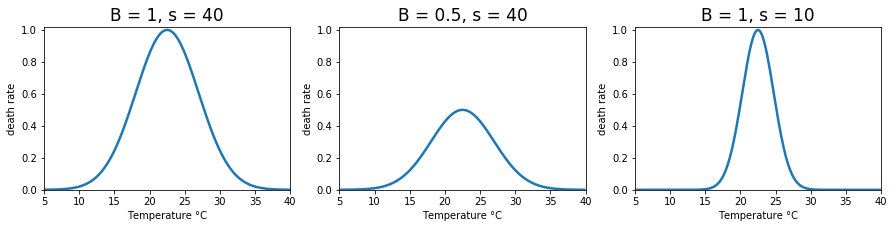

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def death_rate(B, s):
    T = np.arange(5, 40, 0.2)
    T_opt = 22.5
    beta = B * np.exp(-(T - T_opt)**2 / s)
    return beta

T = np.arange(5, 40, 0.2)
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
death_rates = {0:[death_rate(1, 40),1, 40],
               1:[death_rate(0.5, 40), 0.5, 40],
               2:[death_rate(1, 10), 1, 10]}
for i, death_rate in death_rates.items():
    axs[i].plot(T, death_rate[0], linewidth = 2.5)
    axs[i].set_xlabel('Temperature °C')
    axs[i].set_ylabel('death rate')
    axs[i].axis([5, 40, 0, 1.02])  
    axs[i].set_title(f'B = {death_rate[1]}, s = {death_rate[2]}', fontsize = 17)




In the above cell, we see that when $B=1$ and $s=40$, we obtain a normal distribution of temperature that achieves a maximum growth rate of $1$ at $22.5°C$ and that decays near $5°C$ and $40°C$. In contrast, when we set $B=0.5$ and $s=40$, the maximum growth rate is 0.5. That is why the authors mention that the $B$ parameter is related to environmental conditions, since $B$ controls the maximum growth rate of the daisies. In addition, when we set $B=1$ and $s=10$ we obtain a thiner distribution. This is because $s$ controls the variability from the optimum temperature. Here we will be using $B=1$ and $s=40$. The authors say that using a gaussian function, rather than a parable like in the original model, prevents the daisies from reducing their population in an abrupt way when the temperature is near $5°C$ or $40°C$.

Now let's see how Paiva etl al. (2014) modified the radiative balance of Daisyworld. Following Nevison et. al. (1999), they introduced a ODE to model the change in the effective temperature due to the radiative unbalance, but this time they added a term for the green house effect:

\begin{equation} 
\frac{dT_e}{dt} = \frac{1}{c}[S L(1 -A) - \sigma T_{e}^4(1-E)]
\end{equation}

Where $T_e$ is the effective temperature, $c$ is the thermal inertia of the planet, $S$ is the radiation reaching the planet, $L$ is a dimensionless number that controls the solar luminosity, $A$ is the average albedo of the planet, $\sigma$ is the Steffan-Botlzman's constant, and $E$ is a term that represents the green house effect, and is given by the equation:

\begin{equation}
\frac{d E}{dt} = a - b E (\alpha_w + \alpha_b)
\end{equation}

Where $a$ is a parameter related to the emission of green house gases, $b$ is related to the gas absorption, and $\alpha_w$ and $\alpha_b$ are the fraction areas of white and black daisies in the planet.

Let's analyze this equations quantitatively. The equation for the effective temperature depends on the total radiation reaching the planet, and on the total radiation that the planet emits. If the radiation reaching the planet is greater than the radiation leaving the planet, the effective temperature will augment at a rate controlled by the thermal inertia. And in the opposite case, the temperature will augment. Now, the term for the green house effect $E$ affects the total radiation that the planet emits. If it is negative, it augments the emitted radiation and decreases the temperature. If it is positive, it decreases the emitted radiation and makes the temperature increase.

Now, $E$ depends on the term for emission of gases $a$ and on the term for absorption $b$. If the emission of gases in greater than the absorption, $E$ will be positive and it will contribute to augment the effective temperature. In the opposite case it will decrease the temperature. When there is a perfect balance, $E=0$ and there is no green house effect.

Now that we have a qualitative understanding of this equations, let's solve the model to see how introducing the green house effect in Daisyworld affects the daisies.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class Greenhouse_Daisywolrd():
    q = 2064250710.0 #20 # Heat Transfer Coefficient
    sigma = 1789  #Stefan-Boltzman Constant
    S = 2.89e+13  # Solar constant
    
    
    def __init__(self
                ,death_rate =.3 #death rate of daysies
                ,albedo_w=0.75  #white daysies albedo
                ,albedo_g=0.5  #Free ground albedo      
                ,albedo_b=0.25  #Black daysies albedo
                ,area_w= 0.3 # Fraction area of white daisies
                ,area_b= 0.3 # Fraction area of black daisies
                ,cp = 3e+13 # thermal inertia
                ,L = 1 # Solar luminosity constant
                ,a = 1e-4 # Green house emission constant
                ,b = 1e-1 # Green house absorption constant
                ):
        'Initilize all the constants and variables'
        self.death_rate = death_rate
        self.albedo_w = albedo_w
        self.albedo_g = albedo_g
        self.albedo_b = albedo_b
        self.area_w = area_w
        self.area_b = area_b
        self.area_g = 1 - self.area_b - self.area_w # Equation 2
        self.cp = cp
        self.L = L
        self.a = a
        self.b = b
        self.albedo_total = self.area_w * self.albedo_w + self.area_b * self.albedo_b + self.area_g * self.albedo_g
        self.E = 0
        self.Te = ((self.S * self.L * (1- self.albedo_total) / self.sigma) ** 0.25)- 273 #Equation 4
        self.Tw = (self.q*(self.albedo_total - self.albedo_w) + (self.Te +273)**4 )**.25 -273
        self.Tb = (self.q*(self.albedo_total - self.albedo_b)+ (self.Te +273)**4 )**.25 -273
        self.Bw = 1 -0.003265 * ((22.5-self.Tw)**2) #Equation 2
        self.Bb = 1 -0.003265 * ((22.5-self.Tb)**2) #Equation 2
        
    def update_area_g(self):
        'Calclate area of free ground'
        self.area_g = 1 - self.area_b - self.area_w 
        return self.area_g
    
    def update_albedo_total(self):
        self.albedo_total = self.area_w * self.albedo_w + self.area_b * self.albedo_b + self.area_g * self.albedo_g

    def update_green_house_effect(self, h):
        self.E += h* (self.a - self.b * self.E * (self.albedo_w + self.albedo_b))
    
    def update_global_temp(self, h):
        self.Te += h * (self.S * self.L * (1- self.albedo_total) - \
                        self.sigma * (1 - self.E) * ((self.Te + 273) **4) ) / self.cp 

    
    def update_daisies_temp(self):
        self.Tw = (self.q*(self.albedo_total - self.albedo_w) + (self.Te +273)**4 )**.25 -273
        self.Tb = (self.q*(self.albedo_total - self.albedo_b)+ (self.Te +273)**4 )**.25 -273
        #Linear aproximation case (q = 20)
        #self.Tw = self.q*(self.albedo_total-self.albedo_w)+ self.Te 
        #self.Tb = self.q*(self.albedo_total-self.albedo_b)+ self.Te 
    
    def update_growth_rate(self):
        self.Bw = 1 -0.003265 * ((22.5-self.Tw)**2)
        self.Bb = 1 -0.003265 * ((22.5-self.Tb)**2)
    
    
    def solve_model(self, iterations = 12000, h = 0.1, store_values = False):
        'Solve equation 1 with euler method and recalculate all other variables'
        AW, AB, AG, TW, TB, TE = ([],[],[],[],[],[])
        for i in range(iterations):
            self.area_w += h * self.area_w * (self.Bw * self.area_g -self.death_rate)
            self.area_b += h * self.area_b * (self.Bb * self.area_g -self.death_rate)
            self.update_area_g()
            self.update_albedo_total()
            self.update_green_house_effect(h)
            self.update_global_temp(h)
            self.update_daisies_temp()
            self.update_growth_rate()
            if store_values:
                AW.append(self.area_w)
                AB.append(self.area_b)
                AG.append(self.area_g)
                TW.append(self.Tw)
                TB.append(self.Tb)
                TE.append(self.Te) 
        if store_values:
            self.AW = AW
            self.AB = AB
            self.AG = AG
            self.TW = TW
            self.TB = TB
            self.TE = TE
    
    def plot_model(self):
        time = (np.arange(0, len(self.AB)) / 10).tolist()
        plt.figure()
        plt.plot(time, self.AB, 'k', linewidth=2, label='Black')
        plt.plot(time, self.AW, 'g',linewidth=2,label='White')
        plt.xlabel('Time (years)', fontsize=18)
        plt.ylabel(r'Fraction area area_i', fontsize=18)
        plt.title('Change in daisies population', fontsize=20)
        legend = plt.legend(loc=1, shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        
        plt.figure()
        plt.plot(time, self.TB, 'k', linewidth=2, label='Tb')
        plt.plot(time, self.TW, 'g', linewidth=2, label='Tw' )
        plt.plot(time, self.TE, 'r', linewidth=2, label='Te' )
        plt.xlabel('Time (years)', fontsize=18)
        plt.ylabel(r'Temperature (°C)', fontsize=18)
        plt.title('Change in Temperature', fontsize=20)
        legend = plt.legend(loc=1, shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        
        
    
    def change_luminosity(self, L, iterations = 12000, h = 0.1):
        '''
        Change the sola luminosity in the model
        INPUT:
            self: Daisywolrd class
            L (lIST): list describing change in luminosity.
        '''
        #iteration parameters
        n = len(L)
        # lists to store values
        change_lum_TE, change_lum_AW, change_lum_AB, change_lum_AG = ([],[],[],[])
        # initial values
        area_w, area_b, albedo_w, albedo_b, albedo_g, death_rate =\
        self.area_w, self.area_b, self.albedo_w, self.albedo_b, self.albedo_g, self.death_rate
        for i in range(n):
            model = Unbalanced_Daisywolrd(area_w=area_w, area_b = area_b)
            model.L = L[i]
            model.solve_model(iterations, h)
            change_lum_AW.append(model.area_w)
            change_lum_AB.append(model.area_b)
            change_lum_AG.append(model.area_g)
            change_lum_TE.append(model.Te)
        self.change_lum_TE = np.array(change_lum_TE)
        self.change_lum_AW = np.array(change_lum_AW)
        self.change_lum_AB = np.array(change_lum_AB)
        self.change_lum_AG= np.array(change_lum_AG)
        self.L = L
        self.no_life_Te = (self.S * self.L * (1- 0.5) / self.sigma)**0.25-273
    
    def plot_change_luminosity(self):
        plt.figure()
        plt.plot(self.L, self.change_lum_AB, 'k', linewidth=3, label='Black')
        plt.plot(self.L, self.change_lum_AW, 'g',linewidth=3,label='White')
        #plt.plot(self.L, self.change_lum_AB + self.change_lum_AW, 'k--', linewidth=3, label='Sum')
        plt.xlabel('Solar Luminosity $L$', fontsize=18)
        plt.ylabel(r'Fraction area area_i', fontsize=18)
        plt.title('Change in daisies population', fontsize=20)
        plt.axis([0.4, 1.8, -0.1, 0.8])
        legend = plt.legend(loc=1, shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        # Set the fontsize
        for label in legend.get_texts():
            label.set_fontsize('large')
        for label in legend.get_lines():
            label.set_linewidth(1.5)  # the legend line width
            
        plt.figure() 
        plt.plot(self.L, self.change_lum_TE, 'g', linewidth=3, label='T with daisies')
        plt.plot(self.L, self.no_life_Te , 'k--', linewidth=3, label='T without daisies')
        plt.xlabel('Solar Luminosity $L$', fontsize=18)
        plt.ylabel('$T $ [$^\circ C$]', fontsize=18)
        plt.title('Change in effective Temparetaure', fontsize=20)
        plt.axis([0.4, 1.6, -30, 70])
        legend = plt.legend(loc=4, shadow=True)
        frame = legend.get_frame()
        frame.set_facecolor('0.90')
        # Set the fontsize
        for label in legend.get_texts():
            label.set_fontsize('large')
        for label in legend.get_lines():
            label.set_linewidth(1.5)  # the legend line width
        plt.show()
            

        

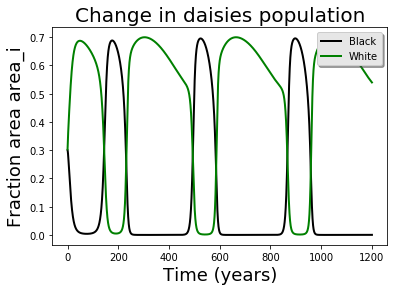

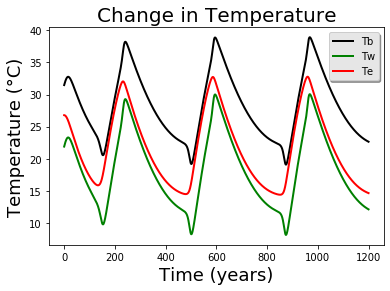

In [13]:
model = Greenhouse_Daisywolrd( a=10e-4, b=10e-3)
model.solve_model(store_values = True)
model.plot_model()